In [1]:
print_imports()

Loaded modules:
Numpy                np              1.12.1
Pandas               pd              0.22.0
Keras                ks              2.0.6

Matplotlib           mpl             2.1.2
matplotlib.pyplot    plt             No version specified
matplotlib.image     mpimg           No version specified
Seaborn              sns             0.8.1
PIL                  PIL             5.0.0

ExergyUtilities      exergy          2.0.

pyspark              NOT LOADED      No version specified


In [2]:
# adapted from https://github.com/tdunning/python-llr

def cmp(a, b):
    return (a > b) - (a < b) 

from collections import Counter 
import math
from functools import reduce

def denormEntropy(counts):
    '''Computes the entropy of a list of counts scaled by the sum of the counts. If the inputs sum to one, this is just the normal definition of entropy'''
    counts = list(counts)
    total = float(sum(counts))
    # Note tricky way to avoid 0*log(0)
    return -sum([k * math.log(k/total + (k==0)) for k in counts])

def llr_2x2(k11, k12, k21, k22):
    '''Special case of llr with a 2x2 table'''
    return 2 * abs(denormEntropy([k11+k12, k21+k22]) +
                denormEntropy([k11+k21, k12+k22]) -
                denormEntropy([k11, k12, k21, k22]))

def llr_root(k11, k12, k21, k22):
    '''Computes a score for a 2x2 contingency table, but then adds a sign according to whether k11 is larger (result is positive) or smaller (result is negative) than might be expected. The magnitude of the result can be roughly interpreted on a scale similar to standard deviations'''
    row = k11 + k21
    total = (k11 + k12 + k21 + k22)
    sign = cmp(float(k11) / (k11 + k12), float(row) / total)
    return math.copysign(math.sqrt(llr_2x2(k11, k12, k21, k22)), sign)

In [3]:
rawdata = np.array([
    [5,5,0,0,0,0],
    [0,0,5,5,0,0],
    [0,0,0,0,5,5],
    [0,1,5,5,5,0],
    [1,1,5,0,5,5],
    [5,5,0,5,1,1],
    [5,0,0,5,0,1],
    [5,5,5,0,1,0]
    ])
    
likes = np.array([[1 if x == 5 else 0 for x in row] for row in rawdata])
pd.DataFrame(likes)

,0,1,2,3,4,5
0,1,1,0,0,0,0
1,0,0,1,1,0,0
2,0,0,0,0,1,1
3,0,0,1,1,1,0
4,0,0,1,0,1,1
5,1,1,0,1,0,0
6,1,0,0,1,0,0
7,1,1,1,0,0,0


In [6]:
cooccurrence_matrix = np.dot(likes.transpose(), likes)
pd.DataFrame(cooccurrence_matrix)

,0,1,2,3,4,5
0,4,3,1,2,0,0
1,3,3,1,1,0,0
2,1,1,4,2,2,1
3,2,1,2,4,1,0
4,0,0,2,1,3,2
5,0,0,1,0,2,2


In [7]:
np.fill_diagonal(cooccurrence_matrix, 0)
pd.DataFrame(cooccurrence_matrix)

,0,1,2,3,4,5
0,0,3,1,2,0,0
1,3,0,1,1,0,0
2,1,1,0,2,2,1
3,2,1,2,0,1,0
4,0,0,2,1,0,2
5,0,0,1,0,2,0


In [8]:
size = cooccurrence_matrix.shape[0]
print(size)

6


In [11]:
sums = np.array([row.sum() for row in cooccurrence_matrix[:,0:size]])
sums

array([6, 5, 7, 6, 5, 3])

In [12]:
total = sums.sum()
size, sums, total

(6, array([6, 5, 7, 6, 5, 3]), 32)

In [16]:
type(cooccurrence_matrix[0,0])

numpy.int64

In [17]:
a_b = cooccurrence_matrix[0,0].tolist()
a_b
type(a_b)

int

In [24]:
thislist = list()
for i in range(0, size):
    for j in range(0, size):
        # Convert his indexed item to an int
        a_b = cooccurrence_matrix[i,j].tolist()
        
        a_not_b = (sums[i] - a_b).tolist()
        b_not_a = (sums[j] - a_b).tolist()
        not_ab = (total - (a_b + sums[i] + sums[j])).tolist()
        this = (i, j, llr_root(a_b, a_not_b, b_not_a, not_ab))
        print(*this)
        thislist.append(this)
        

0 0 -1.671630571360789
0 1 2.033620752749888
0 2 -0.4444608330501006
0 3 0.7721212322079151
0 4 -1.5102415112211136
0 5 -1.1470194399358786
1 0 2.033620752749888
1 1 -1.3647652539835755
1 2 -0.19582196118803194
1 3 1.1920928955078125e-07
1 4 -1.3647652539835755
1 5 -1.0369825130804433
2 0 -0.4444608330501006
2 1 -0.19582196118803194
2 2 -1.9932131287507497
2 3 0.5199643772432565
2 4 0.8219975087691875
2 5 0.4161095064184788
3 0 0.7721212322079151
3 1 1.1920928955078125e-07
3 2 0.5199643772432565
3 3 -1.671630571360789
3 4 1.1920928955078125e-07
3 5 -1.1470194399358786
4 0 -1.5102415112211136
4 1 -1.3647652539835755
4 2 0.8219975087691875
4 3 1.1920928955078125e-07
4 4 -1.3647652539835755
4 5 2.027561328129231
5 0 -1.1470194399358786
5 1 -1.0369825130804433
5 2 0.4161095064184788
5 3 -1.1470194399358786
5 4 2.027561328129231
5 5 -0.7885438972362838


In [36]:
#[a,b].join("-")

"-".join([str(1),str(2)])

'1-2'

In [58]:
labels = ["-".join([str(a),str(b)]) for a,b,c in thislist]
values = [c for a,b,c in thislist]
values = np.array(values)
values = values.reshape(6,6)
print(values)

[[ -1.67163057e+00   2.03362075e+00  -4.44460833e-01   7.72121232e-01
   -1.51024151e+00  -1.14701944e+00]
 [  2.03362075e+00  -1.36476525e+00  -1.95821961e-01   1.19209290e-07
   -1.36476525e+00  -1.03698251e+00]
 [ -4.44460833e-01  -1.95821961e-01  -1.99321313e+00   5.19964377e-01
    8.21997509e-01   4.16109506e-01]
 [  7.72121232e-01   1.19209290e-07   5.19964377e-01  -1.67163057e+00
    1.19209290e-07  -1.14701944e+00]
 [ -1.51024151e+00  -1.36476525e+00   8.21997509e-01   1.19209290e-07
   -1.36476525e+00   2.02756133e+00]
 [ -1.14701944e+00  -1.03698251e+00   4.16109506e-01  -1.14701944e+00
    2.02756133e+00  -7.88543897e-01]]


### Exercise

So far we've used the "people who liked A were unusually likely to like B" statistics to make predictions, but we've ignored the information we have about dislikes. Can you find a way to improve the results by leveraging the 1 values in the rawdata (the dislikes)?

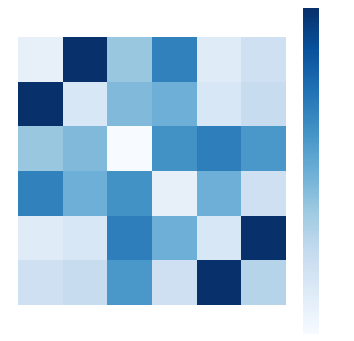

In [107]:
this_c = cmap='hot'
this_c = cmap=plt.cm.Blues

fig=plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1,1,1)


ax.xaxis.set_ticks_position('top') # the rest is the same
ax.grid(False)

#ax.invert_yaxis()
#ax.xaxis.set_label_position('top')
img = ax.imshow(values, this_c)




#fig.colorbar(img, ax=ax, fraction=0.046, pad=0.04) 
fig.colorbar(img, ax=ax);
plt.setp(ax.get_xticklabels(), fontsize=12);
plt.setp(ax.get_yticklabels(), fontsize=12);

#plt.colorbar(this_c)
#plt.show()
#plt.colorbar(this_c, ax=ax)
#plt.colorbar(this_c)
#ax.colorbar(img, cax=this_c)

#img = ax.imshow(image_file)
#plt.colorbar(img, ax=ax)


ValueError: shape mismatch: objects cannot be broadcast to a single shape

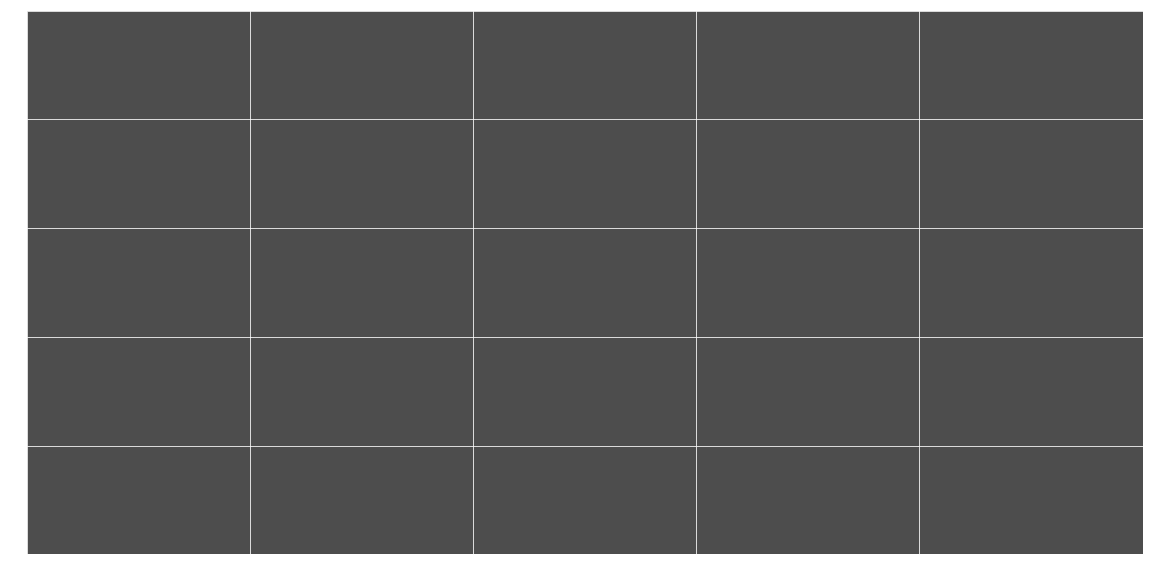

In [83]:
#figure 
fig=plt.figure(figsize=(20, 10))

plt.bar(labels,values)

In [ ]:
|